In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%pwd

'/home/bene/projects/generative-models/examples/torch_autoencoder'

In [3]:
%cd ../..
%pwd

/home/bene/projects/generative-models


'/home/bene/projects/generative-models'

In [4]:
import torch
import torchvision
import torchvision.transforms as transforms

import numpy as np

from gempy.torch.encoder import ConvEncoder
from gempy.torch.decoder import ConvDecoder
from gempy.torch.auto_encoder import AutoEncoder

import matplotlib.pyplot as plt

In [5]:
def get_MNIST(batch_size, dataset_directory, dataloader_workers, source='MNIST'):
    # Prepare dataset for training
    train_transformation = torchvision.transforms.Compose([torchvision.transforms.ToTensor(),])
    
    data_source = getattr(torchvision.datasets, source)
    
    train_dataset = data_source(root=dataset_directory, train=True, download=True, transform=train_transformation)

    test_dataset =  data_source(root=dataset_directory, train=False, download=True, transform=train_transformation)

    # Prepare Data Loaders for training and validation
    train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True,
                                               pin_memory=True, num_workers=dataloader_workers)

    # Prepare Data Loaders for training and validation
    test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=False,
                                              pin_memory=True, num_workers=dataloader_workers)

    return train_dataset, test_dataset, train_loader, test_loader

In [7]:
BATCHSIZE = 16
LEARNINGRATE = 0.001

train_dataset, test_dataset, train_loader, test_loader = get_MNIST(
    BATCHSIZE, 'examples/dat/torch_autoencoder/', 12, 'MNIST'
)

Failed to download (trying next):
HTTP Error 503: Service Unavailable



31.0%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

89.9%IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)

100.0%


Extracting examples/dat/torch_autoencoder/MNIST/raw/t10k-images-idx3-ubyte.gz to examples/dat/torch_autoencoder/MNIST/raw



112.7%

Extracting examples/dat/torch_autoencoder/MNIST/raw/t10k-labels-idx1-ubyte.gz to examples/dat/torch_autoencoder/MNIST/raw

Processing...
Done!



/home/bene/anaconda3/envs/gempy/lib/python3.8/site-packages/torchvision/datasets/mnist.py:502: UserWarning: The given NumPy array is not writeable, and PyTorch does not support non-writeable tensors. This means you can write to the underlying (supposedly non-writeable) NumPy array using the tensor. You may want to copy the array to protect its data or make it writeable before converting it to a tensor. This type of warning will be suppressed for the rest of this program. (Triggered internally at  /opt/conda/conda-bld/pytorch_1616554788289/work/torch/csrc/utils/tensor_numpy.cpp:143.)
  return torch.from_numpy(parsed.astype(m[2], copy=False)).view(*s)


input shape: (1, 28, 28)


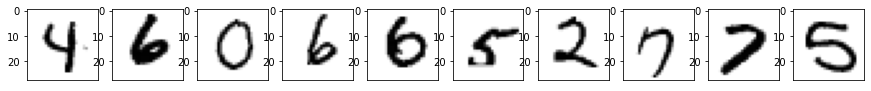

In [8]:
f, axes = plt.subplots(1, 10, figsize=(15, 5))
for ax in axes:
    tensor = train_dataset[np.random.randint(len(train_dataset))][0]
    ax.imshow(tensor.detach().numpy().transpose(1,2,0), cmap='binary')
    ax.set_xticks([]); ax.set_yticks

input_shape = tuple(train_dataset[0][0].shape)
print('input shape:', input_shape)

In [9]:
z_dim = (2, )
z_labels = ('z', )

In [10]:
device = 'cpu'
if torch.cuda.is_available():
    print (f'GPU available')
    device = 'cuda'

x_random = torch.randn(1, *input_shape)
x_random = x_random.to(device)

GPU available


In [18]:
encoder = ConvEncoder(
    input_shape=input_shape,
    filters=(32, 64, 64, 64),
    kernels_size=(3, 3, 3, 3),
    strides=(1, 2, 2, 1),
    activation='elu',
    latent_shape=z_dim,
    latent_labels=z_labels,
    latent_activation=None,
    use_dropout=0.4,
)

print('Encoder:')
for l in encoder.conv_stack:
    print('- shape:', l[-1], '\tactivation:', l[-2])

encoer = encoder.to(device)
encoder

Encoder:
- shape: (32, 28, 28) 	activation: <function elu at 0x7f0ec82125e0>
- shape: (32, 28, 28) 	activation: None
- shape: (64, 14, 14) 	activation: <function elu at 0x7f0ec82125e0>
- shape: (64, 14, 14) 	activation: None
- shape: (64, 7, 7) 	activation: <function elu at 0x7f0ec82125e0>
- shape: (64, 7, 7) 	activation: None
- shape: (64, 7, 7) 	activation: <function elu at 0x7f0ec82125e0>
- shape: (64, 7, 7) 	activation: None


ConvEncoder(
  (conv_0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop_0): Dropout(p=0.4, inplace=False)
  (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (drop_1): Dropout(p=0.4, inplace=False)
  (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
  (drop_2): Dropout(p=0.4, inplace=False)
  (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (drop_3): Dropout(p=0.4, inplace=False)
  (latent_flatten): Flatten(start_dim=1, end_dim=-1)
  (latent_z): Linear(in_features=3136, out_features=2, bias=True)
)

In [12]:
print('Encoder:')
for l in encoder.conv_stack:
    print('- layer activation: ', l[-2])

Encoder:
- layer activation:  <function leaky_relu at 0x7f0ec8212790>
- layer activation:  None
- layer activation:  <function leaky_relu at 0x7f0ec8212790>
- layer activation:  None
- layer activation:  <function leaky_relu at 0x7f0ec8212790>
- layer activation:  None
- layer activation:  <function leaky_relu at 0x7f0ec8212790>
- layer activation:  None


In [13]:
def show_latent(data_loader=test_loader):
    y_latent = []
    y_labels = []
    for batch_features, batch_labels in data_loader:
        batch_features = batch_features.to(device)
        y = encoder(batch_features)[0].detach().cpu().numpy()
        y_latent.extend(y)
        y_labels.extend(batch_labels.numpy())

    y_latent = np.asarray(y_latent)
    y_labels = np.asarray(y_labels)
    
    digit_map = [y_labels == i for i in range(10)]
    
    plt.figure(figsize=(10,10))
    for i, where_i in enumerate(digit_map):
        selection = y_latent[where_i]    
        plt.scatter(*selection[...,:2].T, label=f'#{i}', alpha=0.5)
    plt.legend()
    
    return y_latent

10000 datapoints


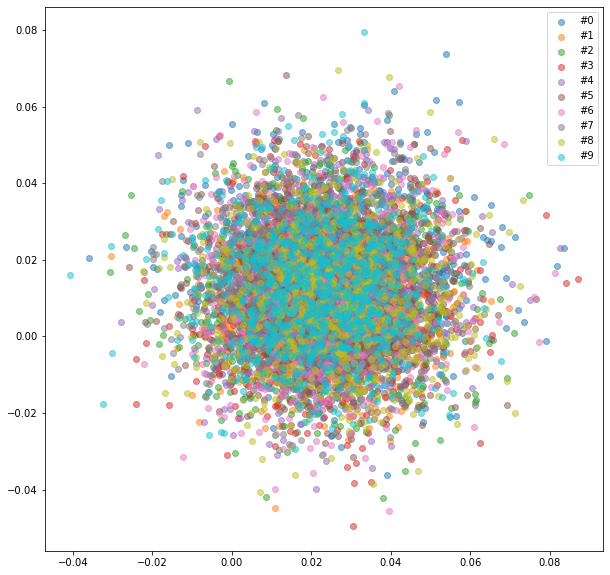

In [14]:
latent_space = show_latent()
print(f'{len(latent_space)} datapoints')

In [17]:
decoder = ConvDecoder(
    latent_shape=z_dim,
    latent_upscale=encoder.conv_stack_shape_out,
    filters=[64, 64, 32, 1],
    kernels_size=[3, 4, 4, 3],
    strides=[1, 2, 2, 1, ],
    activation=['elu', 'elu', 'elu', 'sigmoid'],
    latent_merge=False,
    latent_activation=None,
    use_dropout=False
)

decoder = decoder.to('cuda')

print('Decoder:')
for l in decoder.conv_stack:
    print('- shape:', l[-1], '\tactivation:', l[-2])

decoder

Decoder:
- shape: (64, 7, 7) 	activation: <function elu at 0x7f0ec82125e0>
- shape: (64, 14, 14) 	activation: <function elu at 0x7f0ec82125e0>
- shape: (32, 28, 28) 	activation: <function elu at 0x7f0ec82125e0>
- shape: (1, 28, 28) 	activation: <built-in method sigmoid of type object at 0x7f0f2d5fbca0>


ConvDecoder(
  (decode_latent_0): Linear(in_features=2, out_features=3136, bias=True)
  (decode_conv_t_0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (decode_conv_t_1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (decode_conv_t_2): ConvTranspose2d(64, 32, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
  (decode_conv_t_3): ConvTranspose2d(32, 1, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
)

In [19]:
auto_encoder = AutoEncoder(
    encoder=encoder,
    decoder=decoder,
)

auto_encoder = auto_encoder.to(device)
auto_encoder

AutoEncoder(
  (encoder): ConvEncoder(
    (conv_0): Conv2d(1, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (drop_0): Dropout(p=0.4, inplace=False)
    (conv_1): Conv2d(32, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (drop_1): Dropout(p=0.4, inplace=False)
    (conv_2): Conv2d(64, 64, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (drop_2): Dropout(p=0.4, inplace=False)
    (conv_3): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (drop_3): Dropout(p=0.4, inplace=False)
    (latent_flatten): Flatten(start_dim=1, end_dim=-1)
    (latent_z): Linear(in_features=3136, out_features=2, bias=True)
  )
  (decoder): ConvDecoder(
    (decode_latent_0): Linear(in_features=2, out_features=3136, bias=True)
    (decode_conv_t_0): ConvTranspose2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (decode_conv_t_1): ConvTranspose2d(64, 64, kernel_size=(4, 4), stride=(2, 2), padding=(1, 1))
    (decode_conv_t_2): ConvTranspose2d(64,

In [20]:
# Print model's state_dict
print("Model's state_dict:")
for param_tensor in auto_encoder.state_dict():
    print(param_tensor, "\t", auto_encoder.state_dict()[param_tensor].size())

Model's state_dict:
encoder.conv_0.weight 	 torch.Size([32, 1, 3, 3])
encoder.conv_0.bias 	 torch.Size([32])
encoder.conv_1.weight 	 torch.Size([64, 32, 3, 3])
encoder.conv_1.bias 	 torch.Size([64])
encoder.conv_2.weight 	 torch.Size([64, 64, 3, 3])
encoder.conv_2.bias 	 torch.Size([64])
encoder.conv_3.weight 	 torch.Size([64, 64, 3, 3])
encoder.conv_3.bias 	 torch.Size([64])
encoder.latent_z.weight 	 torch.Size([2, 3136])
encoder.latent_z.bias 	 torch.Size([2])
decoder.decode_latent_0.weight 	 torch.Size([3136, 2])
decoder.decode_latent_0.bias 	 torch.Size([3136])
decoder.decode_conv_t_0.weight 	 torch.Size([64, 64, 3, 3])
decoder.decode_conv_t_0.bias 	 torch.Size([64])
decoder.decode_conv_t_1.weight 	 torch.Size([64, 64, 4, 4])
decoder.decode_conv_t_1.bias 	 torch.Size([64])
decoder.decode_conv_t_2.weight 	 torch.Size([64, 32, 4, 4])
decoder.decode_conv_t_2.bias 	 torch.Size([32])
decoder.decode_conv_t_3.weight 	 torch.Size([32, 1, 3, 3])
decoder.decode_conv_t_3.bias 	 torch.Size([1]

In [21]:
print('input shape     :', auto_encoder.encoder.conv_stack_shape_in)
print('latent shape     :', auto_encoder.encoder.conv_stack_shape_out)
print('z shape          :', z_dim)
print('output shape    :', auto_encoder.decoder.conv_stack_shape_out)

input shape     : (1, 28, 28)
latent shape     : (64, 7, 7)
z shape          : (2,)
output shape    : (1, 28, 28)


In [22]:
y = auto_encoder(x_random)

print('latent space    :', encoder.latent_torch)
print('output shape    :', y.shape)


latent space    : {'z': tensor([[-0.0555, -0.1538]], device='cuda:0', grad_fn=<AddmmBackward>)}
output shape    : torch.Size([1, 1, 28, 28])


In [23]:
BATCHSIZE = 16
LEARNINGRATE = 0.001

EPOCHS = 200
WINDOW = 5
STOPPING = 1e-4

N_BATCHSIZE_UPDATES = 4

In [24]:
# create an optimizer object
optimizer = torch.optim.Adam(auto_encoder.parameters(),  # link to AE parameters
                             lr=LEARNINGRATE)            # set learning rate

In [25]:
# mean-squared error loss
criterion = torch.nn.MSELoss()

In [26]:
# Print optimizer's state_dict
print("Optimizer's state_dict:")
for var_name in optimizer.state_dict():
    print(var_name, "\t", optimizer.state_dict()[var_name])

Optimizer's state_dict:
state 	 {}
param_groups 	 [{'lr': 0.001, 'betas': (0.9, 0.999), 'eps': 1e-08, 'weight_decay': 0, 'amsgrad': False, 'params': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19]}]


In [27]:
loss_history = []
valid_history = []
variations = []

In [33]:
def early_stopping(loss_history, rate=1e-4, window=5):
    if len(loss_history) < window:
        return False
    
    if np.absolute(np.std(loss_history[-window:])) < rate:
        print(np.absolute(np.std(loss_history[-window:])))
        return True
    
    return False

batchsize_updates = 0

for epoch in range(EPOCHS):
    loss = 0
    valid = 0
    for batch_features, _ in train_loader:
        # reshape mini-batch data to [N, 784] matrix
        # load it to the active device
        batch_features = batch_features.to(device)
        
        # reset the gradients back to zero
        # PyTorch accumulates gradients on subsequent backward passes
        optimizer.zero_grad()
        
        # compute reconstructions
        outputs = auto_encoder(batch_features)
        
        # compute training reconstruction loss
        train_loss = criterion(outputs, batch_features)
        
        # compute accumulated gradients
        train_loss.backward()
        
        # perform parameter update based on current gradients
        optimizer.step()
        
        # add the mini-batch training loss to epoch loss
        loss += train_loss.item()
    
    for test_batch, _ in test_loader:
        test_batch = test_batch.to(device)
        outputs = auto_encoder(test_batch)
        test_loss = criterion(outputs, test_batch)
        valid += test_loss.item()
    
    # compute the epoch training loss
    loss = loss / len(train_loader)
    loss_history.append(loss)
                        
    valid = valid / len(test_loader)
    valid_history.append(valid)
    
    # display the epoch training loss
    print("epoch : {}/{}, loss = {:.6f}, valid = {:.6f}".format(epoch + 1, EPOCHS, loss, valid))
    
    if False and early_stopping(loss_history, rate=STOPPING, window=WINDOW):
        
        if batchsize_updates < N_BATCHSIZE_UPDATES:
            batchsize_updates += 1
            BATCHSIZE = int(1.5 * BATCHSIZE)
            train_dataset, test_dataset, train_loader, test_loader = get_MNIST(
                BATCHSIZE, 'examples/dat/torch_autoencoder/', 12, 'MNIST')
            print(f"update batchsize to {BATCHSIZE}")
            
        else:
            print(f"early stopping: could not improve validation of model in range {STOPPING} in {WINDOW} consecutive epochs")
            break
        
        

epoch : 1/200, loss = 0.040052, valid = 0.040133
epoch : 2/200, loss = 0.039999, valid = 0.040073
epoch : 3/200, loss = 0.040020, valid = 0.039988
epoch : 4/200, loss = 0.039998, valid = 0.039899
epoch : 5/200, loss = 0.039988, valid = 0.039912
epoch : 6/200, loss = 0.039989, valid = 0.040130
epoch : 7/200, loss = 0.039978, valid = 0.039810
epoch : 8/200, loss = 0.039905, valid = 0.039838
epoch : 9/200, loss = 0.039898, valid = 0.040226
epoch : 10/200, loss = 0.039896, valid = 0.039924
epoch : 11/200, loss = 0.039879, valid = 0.040093
epoch : 12/200, loss = 0.039876, valid = 0.039904
epoch : 13/200, loss = 0.039813, valid = 0.039953
epoch : 14/200, loss = 0.039846, valid = 0.039712
epoch : 15/200, loss = 0.039834, valid = 0.039770
epoch : 16/200, loss = 0.039812, valid = 0.039883
epoch : 17/200, loss = 0.039799, valid = 0.039943
epoch : 18/200, loss = 0.039794, valid = 0.039718
epoch : 19/200, loss = 0.039801, valid = 0.039752
epoch : 20/200, loss = 0.039772, valid = 0.039782
epoch : 2

epoch : 164/200, loss = 0.039013, valid = 0.038957
epoch : 165/200, loss = 0.038971, valid = 0.039038
epoch : 166/200, loss = 0.038922, valid = 0.039068
epoch : 167/200, loss = 0.038967, valid = 0.038876
epoch : 168/200, loss = 0.038973, valid = 0.039030
epoch : 169/200, loss = 0.038938, valid = 0.038942
epoch : 170/200, loss = 0.038965, valid = 0.039046
epoch : 171/200, loss = 0.038974, valid = 0.039053
epoch : 172/200, loss = 0.038948, valid = 0.038937
epoch : 173/200, loss = 0.038915, valid = 0.039089
epoch : 174/200, loss = 0.038984, valid = 0.039161
epoch : 175/200, loss = 0.038929, valid = 0.039326
epoch : 176/200, loss = 0.039033, valid = 0.038960
epoch : 177/200, loss = 0.038906, valid = 0.038934
epoch : 178/200, loss = 0.038940, valid = 0.039024
epoch : 179/200, loss = 0.038921, valid = 0.039088
epoch : 180/200, loss = 0.038921, valid = 0.039029
epoch : 181/200, loss = 0.038932, valid = 0.039064
epoch : 182/200, loss = 0.038981, valid = 0.038872
epoch : 183/200, loss = 0.03895

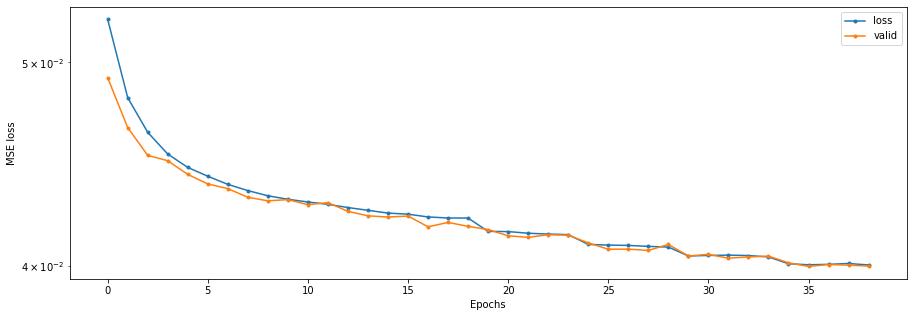

In [29]:
plt.figure(figsize=(15, 5))
plt.semilogy(loss_history, marker='.', label='loss')
plt.semilogy(valid_history, marker='.', label='valid')
plt.xlabel('Epochs'); 
plt.ylabel('MSE loss')
plt.legend();

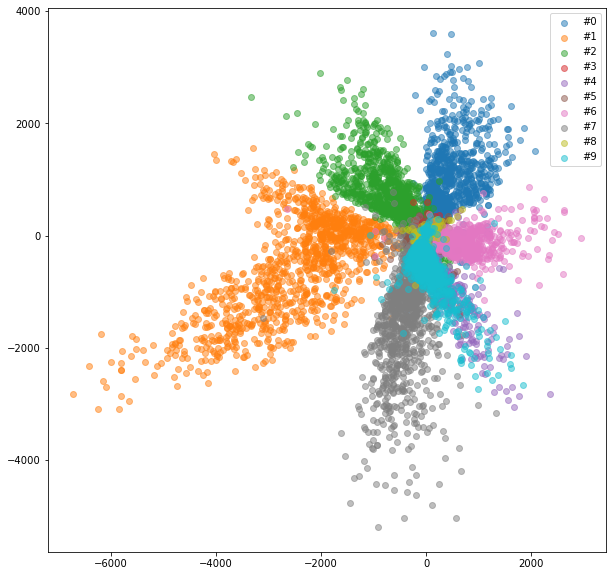

In [30]:
y_latent = show_latent()

In [31]:
y_latent_range = list({'min': li.min(), 'mean': li.mean(), 'max': li.max()} for li in y_latent.T)

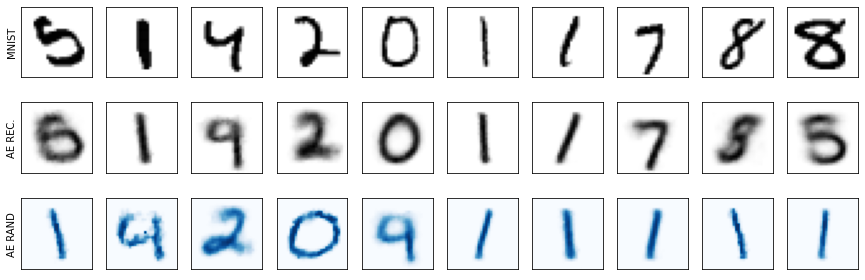

In [32]:
n = 10

z_rand = np.random.rand(n, *z_dim)
for i in range(z_rand.shape[-1]):
    range_i = (y_latent_range[i]['max'] - y_latent_range[i]['min'])
    offset_i = 0.5 - y_latent_range[i]['mean'] / range_i
    z_rand[..., i] -= offset_i
    z_rand[..., i] *= range_i
    
t_rand = torch.from_numpy(z_rand).float().to(device)
y_rand = auto_encoder.decoder(t_rand)
y_numpy = y_rand.detach().cpu().numpy()

f, axes = plt.subplots(3, n, figsize=(15, 5))
tensor_choice = [np.random.randint(len(train_dataset)) for __ in range(n)]

my_subset = torch.utils.data.Subset(train_dataset, tensor_choice)
loader = torch.utils.data.DataLoader(my_subset, batch_size=len(tensor_choice))
for tensors, __ in loader:
    reconst = auto_encoder(tensors.to(device))

    for i, ax in enumerate(axes.T):
        ax[0].imshow(tensors[i].detach().numpy().transpose(1,2,0), cmap='binary')
        ax[1].imshow(reconst[i].detach().cpu().numpy().transpose(1,2,0), cmap='binary')

        ax[2].imshow(y_numpy[i].transpose(1,2,0), cmap='Blues')
        ax[0].set_xticks([]); ax[0].set_yticks([])
        ax[1].set_xticks([]); ax[1].set_yticks([])
        ax[2].set_xticks([]); ax[2].set_yticks([])

    axes[0][0].set_ylabel('MNIST');
    axes[1][0].set_ylabel('AE REC.');
    axes[2][0].set_ylabel('AE RAND');